In [1]:
import gymnasium
import cookiedisaster
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline
import numpy as np
import random

In [2]:
env = gymnasium.make('cookiedisaster/GridWorld-v0', render_mode="rgb_array")

2. Use a linear approximation to approximate $q_\pi(a,s)$ and solve the control problem using Q-learning. 
You may want to consider the use of feature engineering to pre-process the state.

In [3]:
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
dist = np.abs(observation_examples[:, 0] - observation_examples[:, 2]).reshape(-1, 1)
observation_examples = np.hstack((observation_examples, dist))

In [4]:
scaler = StandardScaler()
featurizer = FeatureUnion([
    ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
    ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
    ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
    ("rbf4", RBFSampler(gamma=0.5, n_components=100))
])

feature_transformer = Pipeline([
    ('scaler', scaler),
    ('featurizer', featurizer)
])

feature_transformer.fit(observation_examples)

Pipeline(steps=[('scaler', StandardScaler()),
                ('featurizer',
                 FeatureUnion(transformer_list=[('rbf1', RBFSampler(gamma=5.0)),
                                                ('rbf2', RBFSampler(gamma=2.0)),
                                                ('rbf3', RBFSampler()),
                                                ('rbf4',
                                                 RBFSampler(gamma=0.5))]))])

In [5]:
feature_transformer.transform(observation_examples)

array([[ 0.08939476,  0.1035032 , -0.14139222, ..., -0.14084002,
        -0.14076711,  0.12145665],
       [ 0.01381246,  0.05240636,  0.00874262, ..., -0.02907599,
        -0.09601483, -0.13619278],
       [-0.03300218,  0.05983362,  0.13016301, ..., -0.11772873,
        -0.14087941, -0.05864801],
       ...,
       [ 0.04624153, -0.13306886,  0.02938776, ...,  0.14029253,
         0.14062491,  0.07384241],
       [ 0.13960075,  0.12363447,  0.04219003, ...,  0.12342778,
         0.05607026,  0.12957491],
       [ 0.1175857 ,  0.10784873, -0.1288465 , ...,  0.01038897,
         0.10452648,  0.10184497]], dtype=float32)

In [6]:
def get_state(obs, info):
    agent_pos = obs["agent"]["pos"]
    agent_vel = obs["agent"]["vel"]
    cookie_pos = obs["cookie"]["pos"]
    dist = info["distance"]

    return [agent_pos, agent_vel, cookie_pos, dist]

In [7]:
class FunctionApproximator:
    def __init__(self):
        self.models = []
        for i in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            obs, info = env.reset()
            model.partial_fit([self.featurize_state(get_state(obs, info))], [0])
            self.models.append(model)

    def featurize_state(self, state):
        features = feature_transformer.transform([state])
        return features[0]

    def predict(self, s, a=None):
        state_features = self.featurize_state(s)
        if not a:
            return np.array([m.predict([state_features])[0] for m in self.models])
        else:
            return self.models[a].predict([state_features])[0]

    def update(self, s, a, y):
        features = self.featurize_state(s)
        self.models[a].partial_fit([features], [y])

In [8]:
def random_argmax(arr):
    max_value = np.max(arr)
    max_indices = np.where(arr == max_value)[0]
    random_index = random.choice(max_indices)
    return random_index

In [9]:
def eps_greedy_policy(func_approx, epsilon, action_space):
    def policy_func(state):
        prob_distribution = np.ones(action_space) * epsilon / action_space
        q_values = func_approx.predict(state)
        best_action = random_argmax(q_values)
        prob_distribution[best_action] += (1 - epsilon)
        return prob_distribution

    return policy_func

In [10]:
def q_learning(env, func_approx, num_episodes=100, num_steps=1000, discount_factor=1.0, epsilon_start=1.0,
               epsilon_decay=0.99, epsilon_min=0.1):
    stats = {
        "episode_rewards": np.zeros(num_episodes)
    }

    epsilon = epsilon_start
    policy = eps_greedy_policy(func_approx, epsilon, env.action_space.n)

    for episode in range(1, num_episodes):

        obs, info = env.reset()
        state = get_state(obs, info)

        for step in range(1, num_steps):
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            next_obs, reward, _, _, next_info = env.step(action)
            next_state = get_state(next_obs, next_info)

            stats["episode_rewards"][episode] += reward

            q_values_next = func_approx.predict(next_state)
            td_target = reward + discount_factor * np.max(q_values_next)

            func_approx.update(state, action, td_target)

            print("\rEpisode: {}/{}   Step: {}/{}    {}".format(episode, num_episodes, step, num_steps,
                                                                round(epsilon, 3)), end="")

            state = next_state

        epsilon = max(epsilon_min, epsilon_decay * epsilon)
        policy = eps_greedy_policy(func_approx, epsilon, env.action_space.n)

    return stats

In [12]:
fa = FunctionApproximator()

In [14]:
stats = q_learning(env, fa)

Episode: 99/100   Step: 999/1000    0.373

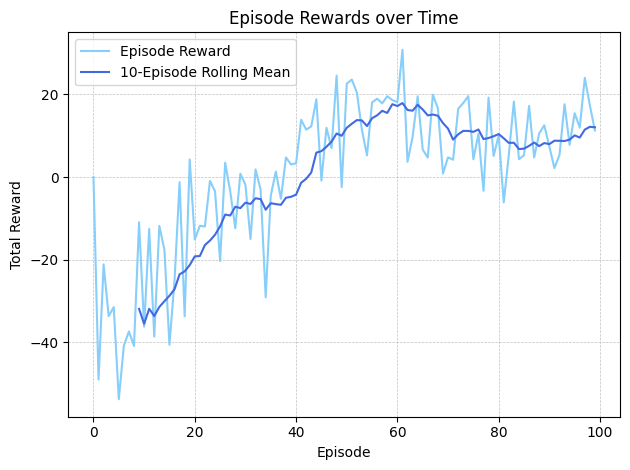

In [15]:
plt.plot(stats["episode_rewards"], color="lightskyblue", label="Episode Reward")
plt.plot(pd.Series(stats["episode_rewards"]).rolling(10).mean(), color="royalblue", label="10-Episode Rolling Mean")
plt.title("Episode Rewards over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(color="silver", linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout()
plt.show()